In [0]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics.pairwise import laplacian_kernel
from sklearn.model_selection import train_test_split

In [95]:
sigmas = {
    "dipole": 1,
    "atomization": 31.622777,
    "gap": 10,
    "homo": 10
}

sigmas = {
    "dipole": 10,
    "atomization": 100,
    "gap": 31.622777,
    "homo": 31.622777
}

results = []

for target in ["atomization","dipole","gap","homo"]:
    # X = np.load('/home/dboiko/SPAHM/SPAHM/1_QM7/representations_SPAHM/LB.minao.npy')
    X = np.load('/home/dboiko/SPAHM/SPAHM/1_QM7/representations_QML/CM.npy')
    y = np.loadtxt(f'/home/dboiko/SPAHM/SPAHM/1_QM7/target/{target}.dat')

    test_idx = np.loadtxt('/home/dboiko/SPAHM/test-indices/QM7_test_indices.dat').astype(int)
    train_indices = np.array([i for i in range(X.shape[0]) if i not in test_idx])

    selected_kernel = laplacian_kernel

    test_size = 0.2
    sigma=sigmas[target]
    eta=1e-5
    n_rep=5

    X_train, X_test, y_train, y_test = X[train_indices], X[test_idx], y[train_indices], y[test_idx]

    all_indices_train = np.arange(X_train.shape[0])
    K_all  = laplacian_kernel(X_train, X_train, 1.0/sigma)
    Ks_all = laplacian_kernel(X_test,  X_train, 1.0/sigma)
    K_all[np.diag_indices_from(K_all)] += eta

    np.random.seed(42)

    train_size = np.linspace(0.1, 0.9, 9)

    for size in tqdm(train_size):
        size_train = int(np.floor(X_train.shape[0]*size))
        maes = []
        for rep in range(n_rep):
            train_idx = np.random.choice(all_indices_train, size = size_train, replace=False)
            y_kf_train = y_train[train_idx]
            K  = K_all [np.ix_(train_idx,train_idx)]
            Ks = Ks_all[:,train_idx]
            alpha = np.linalg.solve(K, y_kf_train)
            y_kf_predict = np.dot(Ks, alpha)
            maes.append(np.mean(np.abs(y_test-y_kf_predict)))

        results.append({
            'target': target,
            'size': size_train,
            'mae': np.mean(maes),
            'std': np.std(maes)
        })

results = pd.DataFrame(results)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.24s/it]


In [88]:
results

,target,size,mae,std
0,atomization,573,9.225823,0.561123
1,atomization,1146,6.315142,0.526400
2,atomization,1719,5.307729,0.173755
3,atomization,2292,4.586249,0.382936
4,atomization,2866,4.277097,0.189329
5,atomization,3439,3.942689,0.118638
6,atomization,4012,3.629434,0.040715
7,atomization,4585,3.519753,0.074322
8,atomization,5158,3.363854,0.101991
9,dipole,573,0.285843,0.006670


In [111]:
comparator_results = pd.read_csv(
    '/home/dboiko/simg-2/experiments/downstream_model/additional_benchmarks/qm7/results_SPAHM_comparison_longer.csv'
)
comparator_results['size'] = comparator_results['fraction']*4585
comparator_results['mae'] = comparator_results['mse']
comparator_results = comparator_results.groupby(['target','size'])['mae'].mean().reset_index()

In [93]:
results_spahm = results.copy()

In [107]:
results_spahm.to_csv('1116_results_spahm.csv', index=False)
results.to_csv('1116_results_cm.csv', index=False)

In [176]:
results_soap = pd.read_csv('/home/dboiko/1117_results_soap.csv')

/tmp/ipykernel_1072437/270542703.py:53: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


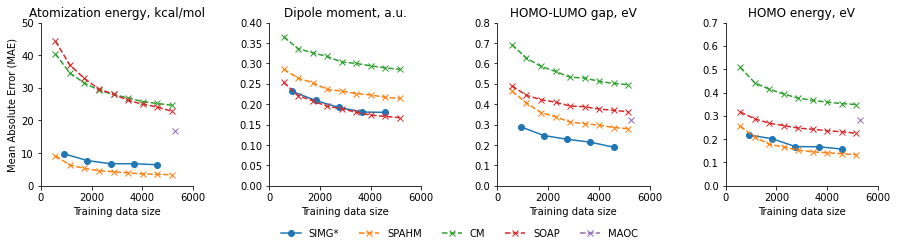

In [179]:
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Arial"]

plt.rcParams["pdf.fonttype"] = 42

fig, axes = plt.subplots(1, 4, figsize=(15, 3))
targets = ["atomization", "dipole", "gap", "homo"]

for i, target in enumerate(targets):
    sub_cmp = comparator_results[comparator_results['target'] == target].copy()
    sub_res_spahm = results_spahm[results_spahm['target'] == target].copy()
    sub_res = results[results['target'] == target].copy()
    sub_res_soap = results_soap[results_soap['target'] == target].copy()

    if target in ['homo', 'gap']:
        sub_cmp['mae'] = 27*sub_cmp['mae']
        sub_res_spahm['mae'] = 27*sub_res_spahm['mae']
        sub_res['mae'] = 27*sub_res['mae']
        sub_res_soap['mae'] = 27*sub_res_soap['mae']

    axes[i].plot(sub_cmp['size'], sub_cmp['mae'], label='SIMG*', linestyle='-', marker='o')
    axes[i].plot(sub_res_spahm['size'], sub_res_spahm['mae'], label='SPAHM', linestyle='--', marker='x')
    axes[i].plot(sub_res['size'], sub_res['mae'], label='CM', linestyle='--', marker='x')
    axes[i].plot(sub_res_soap['size'], sub_res_soap['mae'], label='SOAP', linestyle='--', marker='x')


    if i != 1:
        axes[i].plot(
            5_284, [16.78, None, 0.32, .28][i], label='MAOC', marker='x', linestyle='--'
        )

    axes[i].set_ylim(0, [50, 0.4, 0.8, 0.7][i])
    axes[i].set_xlim(0, 6000)

    target2label = {
        "atomization": "Atomization energy, kcal/mol",
        "dipole": "Dipole moment, a.u.",
        "gap": "HOMO-LUMO gap, eV",
        "homo": "HOMO energy, eV"
    }

    axes[i].set_title(target2label[target])
    axes[i].set_xlabel("Training data size")
    axes[i].spines["top"].set_visible(False)
    axes[i].spines["right"].set_visible(False)

    if i == 0:
        axes[i].set_ylabel("Mean Absolute Error (MAE)")
        axes[i].legend(loc=(1.55, -0.35), frameon=False, ncol=5)
plt.subplots_adjust(wspace=0.5)
plt.tight_layout()
plt.savefig('baseline_comparison.pdf', dpi=300, bbox_inches='tight')

In [175]:
!pwd

/home/dboiko


In [113]:
results_spahm

,target,size,mae,std
0,atomization,573,9.225823,0.561123
1,atomization,1146,6.315142,0.526400
2,atomization,1719,5.307729,0.173755
3,atomization,2292,4.586249,0.382936
4,atomization,2866,4.277097,0.189329
5,atomization,3439,3.942689,0.118638
6,atomization,4012,3.629434,0.040715
7,atomization,4585,3.519753,0.074322
8,atomization,5158,3.363854,0.101991
9,dipole,573,0.285843,0.006670


In [ ]:
comparator_results

In [72]:
results.groupby('target', 'size')['mae'].mean()

KeyError: ('target', 'size')

In [57]:

X = np.load('/home/dboiko/SPAHM/SPAHM/1_QM7/representations_SPAHM/LB.minao.npy')
y = np.loadtxt('/home/dboiko/SPAHM/SPAHM/1_QM7/target/atomization.dat')

In [58]:
test_idx = np.loadtxt('/home/dboiko/SPAHM/test-indices/QM7_test_indices.dat').astype(int)

In [59]:
selected_kernel = laplacian_kernel
test_size = 0.2
# sigma=10 gap
sigma=31.622777
eta=1e-5
n_rep=5

In [60]:
train_indices = np.array([i for i in range(X.shape[0]) if i not in test_idx])

In [61]:
X_train, X_test, y_train, y_test = X[train_indices], X[test_idx], y[train_indices], y[test_idx]

all_indices_train = np.arange(X_train.shape[0])
K_all  = laplacian_kernel(X_train, X_train, 1.0/sigma)
Ks_all = laplacian_kernel(X_test,  X_train, 1.0/sigma)
K_all[np.diag_indices_from(K_all)] += eta

np.random.seed(42)

train_size = np.linspace(0.1, 0.9, 9)

In [62]:
results = []

for size in tqdm(train_size):
    size_train = int(np.floor(X_train.shape[0]*size))
    maes = []
    for rep in range(n_rep):
        train_idx = np.random.choice(all_indices_train, size = size_train, replace=False)
        y_kf_train = y_train[train_idx]
        K  = K_all [np.ix_(train_idx,train_idx)]
        Ks = Ks_all[:,train_idx]
        alpha = np.linalg.solve(K, y_kf_train)
        y_kf_predict = np.dot(Ks, alpha)
        maes.append(np.mean(np.abs(y_test-y_kf_predict)))

    results.append({
        'size': size_train,
        'mae': np.mean(maes),
        'std': np.std(maes)
    })

results = pd.DataFrame(results)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.32s/it]


In [63]:
results.to_csv('results_spahm.csv', index=False)

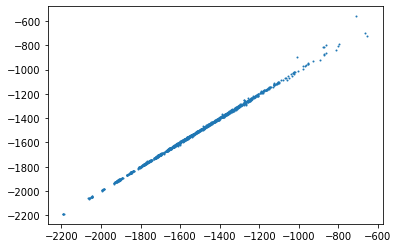

In [64]:
import matplotlib.pyplot as plt
plt.scatter(
    y_test,
    y_kf_predict,
    s=1
)

In [65]:
np.abs(y_test-y_kf_predict).mean()

3.2675255789816515

In [66]:
((y_test-y_kf_predict)**2).mean()

54.37592768562225

In [47]:
results

,size,mae,std
0,573,0.016173,0.000488
1,1146,0.014698,0.000146
2,1719,0.013517,0.000180
3,2292,0.012704,0.000293
4,2866,0.012091,0.000161
5,3439,0.011757,0.000131
6,4012,0.011547,0.000145
7,4585,0.011174,0.000072
8,5158,0.011078,0.000047


In [29]:
X = np.stack(np.load('X_CM.npy', allow_pickle=True))

In [32]:
X_train, X_test, y_train, y_test = X[train_indices], X[test_indices], y[train_indices], y[test_indices]

all_indices_train = np.arange(X_train.shape[0])
K_all  = laplacian_kernel(X_train, X_train, 1.0/sigma)
Ks_all = laplacian_kernel(X_test,  X_train, 1.0/sigma)
K_all[np.diag_indices_from(K_all)] += eta

np.random.seed(42)
results = []

for size in tqdm(train_size):
    size_train = int(np.floor(X_train.shape[0]*size))
    maes = []
    for rep in range(n_rep):
        train_idx = np.random.choice(all_indices_train, size = size_train, replace=False)
        y_kf_train = y_train[train_idx]
        K  = K_all [np.ix_(train_idx,train_idx)]
        Ks = Ks_all[:,train_idx]
        alpha = np.linalg.solve(K, y_kf_train)
        y_kf_predict = np.dot(Ks, alpha)
        maes.append(np.mean(np.abs(y_test-y_kf_predict)))

    results.append({
        'size': size_train,
        'mae': np.mean(maes),
        'std': np.std(maes)
    })

results = pd.DataFrame(results)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:18<00:00,  2.07s/it]


In [33]:
results.to_csv('results_cm.csv', index=False)

In [34]:
results

,size,mae,std
0,568,61.130995,1.343586
1,1136,47.820215,0.474877
2,1704,41.682791,0.802713
3,2272,38.649581,0.494135
4,2840,35.153820,0.450689
5,3408,33.226622,0.406923
6,3976,31.740046,0.234991
7,4544,30.400880,0.319176
8,5112,28.790721,0.200000


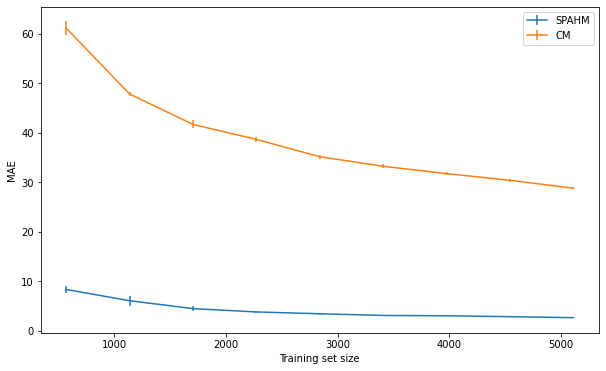

In [35]:
import matplotlib.pyplot as plt

results = pd.read_csv('results_spahm.csv')
results_cm = pd.read_csv('results_cm.csv')

plt.figure(figsize=(10,6))
plt.errorbar(results['size'], results['mae'], yerr=results['std'], label='SPAHM')
plt.errorbar(results_cm['size'], results_cm['mae'], yerr=results_cm['std'], label='CM')
plt.xlabel('Training set size')
plt.ylabel('MAE')
plt.legend()